In [1]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

# Problems with comparing [Gram matrices](https://en.wikipedia.org/wiki/Gramian_matrix)

The style-loss function employed in [Gatys et al](https://arxiv.org/abs/1508.06576) is the sum of the squares (or Froebenius norm) of the differences of Gram matrices between the representative style and the generated image in the feature space of a given layer of the network.  

A [Gram matrix](https://en.wikipedia.org/wiki/Gramian_matrix) is a non-central second moment. The example below is designed to illustrate how variables can have different [central moments](https://en.wikipedia.org/wiki/Moment_(mathematics) (means and covariances) but identical Gram matrices. 


Consider two random vectors, X and Y,  in three dimensional Euclidean space with [multivariate guassian](https://en.wikipedia.org/wiki/Multivariate_normal_distribution) distributions specified $\mathcal{N_3}(mean_X, cov_X)$ and $\mathcal{N_3}(mean_Y, cov_Y)$:



In [2]:
mean_X = np.array([[0.0,-0.5,0.5]])
corr_X = np.array([[1.,-.5,0.],[-.5,1.,0.],[0.,0.,1.]])
sigma_X = np.array([[1., 1., 1.]])
cov_X = sigma_X.T*corr_X*sigma_X #covariance matrix derived from components to ensure positive semi-definite

mean_Y = np.array([[1.,-.5,0.]])
corr_Y = np.array([[1.,0.,-.5],[0.,1.,-.25/np.sqrt(1.25)],[-.5,-.25/np.sqrt(1.25),1.]])
sigma_Y = np.array([[0, 1., np.sqrt(1.25)]])
cov_Y = sigma_Y.T*corr_Y*sigma_Y

Lets generate random samples from these distributions:

In [3]:
samples_X = np.random.multivariate_normal(mean_X[0], cov_X, 10000)
samples_Y = np.random.multivariate_normal(mean_Y[0], cov_Y, 10000)

print("5 samples of X:", "\n", samples_X[:5], "\n")

print("5 samples of Y:", "\n", samples_Y[:5], "\n")

5 samples of X: 
 [[ 1.30226007 -1.45730148  0.09980416]
 [ 0.52909221 -1.34918255 -0.96486426]
 [ 0.50482889 -1.34756658  0.48699767]
 [-1.18177265  0.22841077 -0.65175687]
 [ 0.64447686  0.12951202  0.80160497]] 

5 samples of Y: 
 [[ 1.         -0.9126742   0.98376757]
 [ 1.         -0.79464139  1.23165233]
 [ 1.         -1.04523238  0.73613958]
 [ 1.         -1.2722863   2.40541549]
 [ 1.         -0.14764009 -0.69366296]] 



In [4]:
gram_X = np.matmul(samples_X.T, samples_X)/samples_X.shape[0]
gram_Y = np.matmul(samples_Y.T, samples_Y)/samples_Y.shape[0]

print("Observed gram matrix of X:", "\n", gram_X, "\n")

print("Observed gram matrix of Y:", "\n", gram_Y, "\n")

print("Gatys style-loss:", np.sum((gram_X-gram_Y)**2))

Observed gram matrix of X: 
 [[ 0.99803923 -0.49560595  0.00317961]
 [-0.49560595  1.2449639  -0.27429657]
 [ 0.00317961 -0.27429657  1.27895202]] 

Observed gram matrix of Y: 
 [[ 1.         -0.49155109 -0.00549951]
 [-0.49155109  1.24160472 -0.26368179]
 [-0.00549951 -0.26368179  1.23873601]] 

Gatys style-loss: 0.00204134135224


The style-loss function used in Gatys et al. would see these samples as identical (basically zero loss). Yet, if we plot samples onto an RGB feature space, we see they are visually very different:

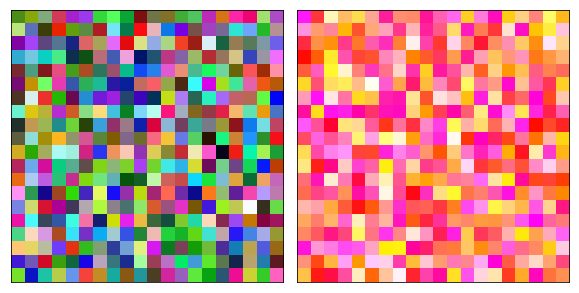

In [5]:
fig, axes = plt.subplots(1, 2, figsize=(10, 10),
                         subplot_kw={'xticks': [], 'yticks': []})

fig.subplots_adjust(hspace=0.3, wspace=0.05)


#plot first 400
axes[0].imshow(samples_X[:400].reshape((20,20,3)))
axes[1].imshow(samples_Y[:400].reshape((20,20,3)))


The sum of squared differences of Graham matrices is not a valid metric on the set of probability distributions. Violates the [Identity of Indiscernibles](https://en.wikipedia.org/wiki/Identity_of_indiscernibles).

A similar example with simplified numbers:

Consider W and Z where  $W$~$\mathcal{N_3}(mean_W, cov_W)$ and $Z$~$\mathcal{N_3}(mean_Z, cov_Z)$:

In [6]:
mean_W = np.array([[1.,1.,1.]])
cov_W = np.zeros((3,3))

mean_Z = np.array([[0.,0.,0.]])
cov_Z = np.ones((3,3))

samples_W = np.random.multivariate_normal(mean_W[0], cov_W, 10000)
samples_Z = np.random.multivariate_normal(mean_Z[0], cov_Z, 10000)

gram_W = np.matmul(samples_W.T, samples_W)/samples_W.shape[0]
gram_Z = np.matmul(samples_Z.T, samples_Z)/samples_Z.shape[0]

print("Observed gram matrix of W:", "\n", gram_W, "\n")

print("Observed gram matrix of Z:", "\n", gram_Z, "\n")

print("Gatys style-loss:", np.sum((gram_W-gram_Z)**2))

Observed gram matrix of W: 
 [[ 1.  1.  1.]
 [ 1.  1.  1.]
 [ 1.  1.  1.]] 

Observed gram matrix of Z: 
 [[ 1.00991674  1.00991674  1.00991674]
 [ 1.00991674  1.00991674  1.00991674]
 [ 1.00991674  1.00991674  1.00991674]] 

Gatys style-loss: 0.000885074960646


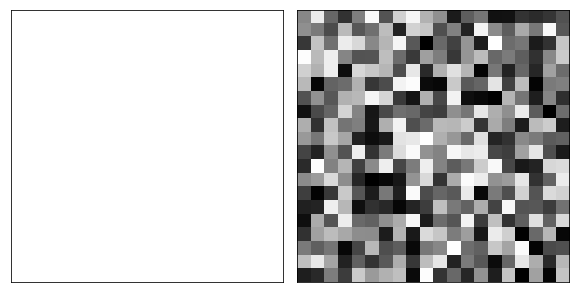

In [7]:
fig, axes = plt.subplots(1, 2, figsize=(10, 10),
                         subplot_kw={'xticks': [], 'yticks': []})

fig.subplots_adjust(hspace=0.3, wspace=0.05)

axes[0].imshow(samples_W[:400].reshape((20,20,3)))
axes[1].imshow(samples_Z[:400].reshape((20,20,3)))


## Wasserstein Distance, on the other hand, is a valid metric for multi-variate Gaussians:

It can be calculated in closed form, but we do have to assume our variables (image features) are of Gaussian measure

In [8]:
def wdist(m1, cov1, m2, cov2): 
  mean_diff = np.sum((m1-m2)**2)
  var_components = np.trace(cov1+cov2)
  #need to round to prevent eigenvalues very close to zero from becoming negative
  var_overlap = np.sum(np.sqrt(np.round(np.linalg.eigvals(np.matmul(cov1,cov2)),5)))
  
  return  np.sqrt(mean_diff+var_components-2*var_overlap)

In [9]:
wdist(mean_X, cov_X, mean_Y, cov_Y), wdist(mean_W, cov_W, mean_Z, cov_Z)

(1.5135220191046239, 2.4494897427831779)

In [10]:
wdist(mean_X, cov_X, mean_Y, cov_Y) == wdist(mean_Y, cov_Y, mean_X, cov_X)

True

In [11]:
(wdist(mean_X, cov_X, mean_Y, cov_Y)**2+wdist(mean_Y, cov_Y, mean_Z, cov_Z)**2) > wdist(mean_X, cov_X, mean_Z, cov_Z)**2

True

# Style Transfer as Optimal Transport

### Historical Foundation: Texture Synthesis

“What features and statistics are characteristics of a texture pattern, so that texture pairs that share the same features and statistics cannot be told apart by pre-attentive human visual perception?”  -- [Bela Julesz](https://en.wikipedia.org/wiki/B%C3%A9la_Julesz)



With Style Transfer, we seek to transfer the 'features and statistics' of a representative style onto a subject image.


#### Is it possible to fully transfer a distribution without assuming any structure (ie transfer a non-parametric distribution)?

In a way, yes, but its computationally intensive because it requires pixel-to-pixel comparisons. In order to perform a full Earth Mover's Distance calculation on two 224x224 images fed into VGG19::

In [12]:
relu1_1_pixels = 224*224
relu1_1_features = 64

distance_matrix_size = relu1_1_features*((relu1_1_pixels)**2)*(32/8)/(10**9)
tflops_per_evaulation = (relu1_1_pixels)**3/(10**12)

print("Distance matrix size in gb for float32 at relu1_1: {:4.1f} gb".format(distance_matrix_size))
print("Once have dist matrix, to calc EMD at relu1_1: {:4.1f} TFLOPS".format(tflops_per_evaulation))

Distance matrix size in gb for float32 at relu1_1: 644.5 gb
Once have dist matrix, to calc EMD at relu1_1: 126.3 TFLOPS
